In [10]:
import numpy as np
from time import time
import torch
import matplotlib.pyplot as plt
import argparse
#from utils import bin_spectrum
import os
import pickle
opj = os.path.join

from torch.distributions import Normal, HalfNormal

import sbi
from sbi.utils.user_input_checks import (
    check_sbi_inputs,
    process_prior,
    process_simulator,
)
import optuna

#from sbi_bmode import sbi_utils#, data # unpickle_from_gpu_to_cpu

from getdist import plots as getdist_plots
from getdist import MCSamples as getdist_MCSamples

In [27]:
indir = '/mnt/home/abayer/cca_project/output/'

r_trues = [0.1, 0.01, 0.001, 0.0001][:]
seed = 0
n_trains = [100, 200, 500, 1000, 10000][:]
n_samples = 10000
n_rounds = 1

# for bins and plotting 
rmin = 0
rmax = 0.3
nbins = 100
r_bin_edges = np.linspace(rmin, rmax, nbins+1)

# fiducial values: r_tensor=0.1, A_lens=1, A_d_BB=5, alpha_d_BB=-0.2, beta_dust=1.59
n_params = 5
param_names = ['r_tensor', 'A_lens', 'A_d_BB', 'alpha_d_BB', 'beta_dust']
param_labels = [r'$r$', r'$A_L$', r'$A_d^{BB}$', r'$\alpha_d^{BB}$', r'$\beta_d$']   
param_labels_g = [l[1:-1] for l in param_labels] # getdist will put in $
param_truths = [None, 1, 5, -0.2, 1.59]

# optuna ranges:
num_atoms0 = 1
num_atoms1 = 100
training_batch_size0 = 20
training_batch_size1 = 120
learning_rate0 = 1e-6
learning_rate1 = 1
clip_max_norm0 = 1e-4
clip_max_norm1 = 1e2

/tmp/ipykernel_151519/3448011948.py:19: FutureWarning: load_study() got {'study_name', 'storage'} as positional arguments but they were expected to be given as keyword arguments.
  study = optuna.load_study(study_name, storage)


Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in


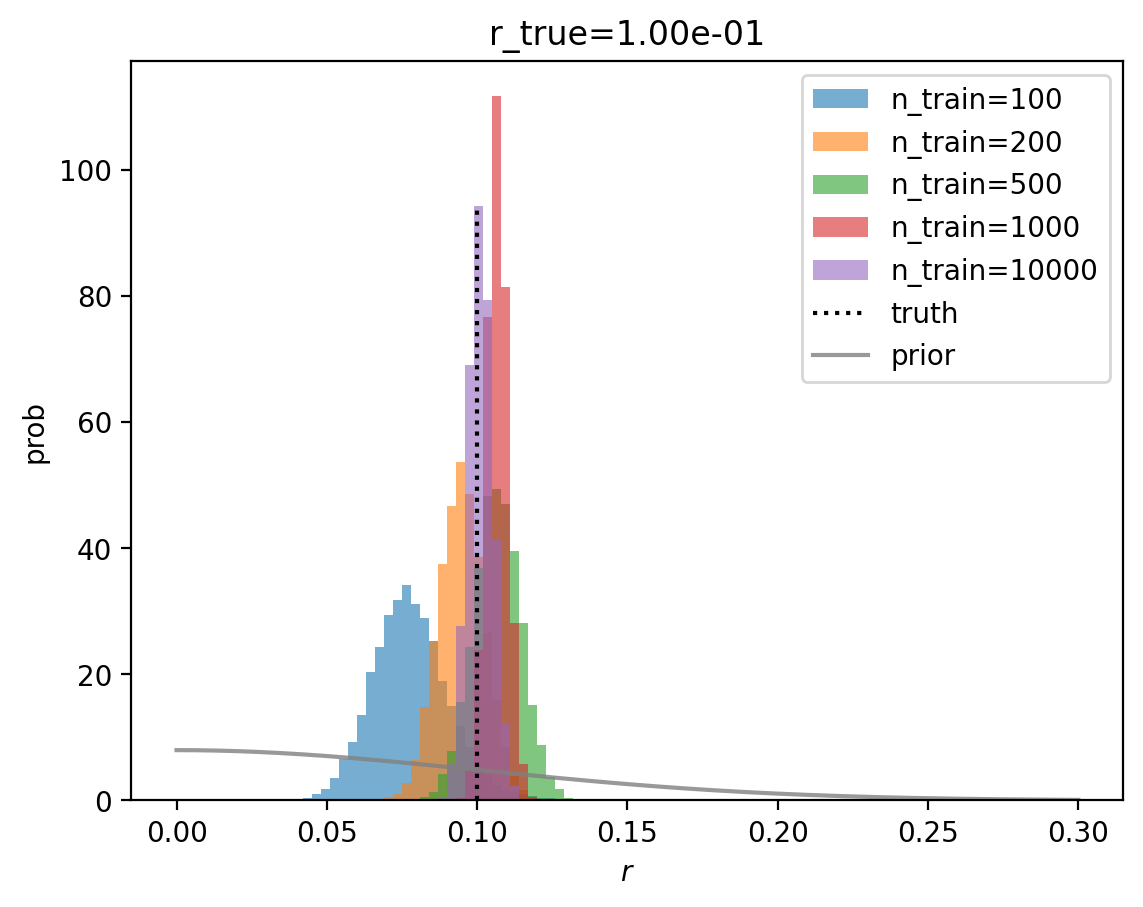

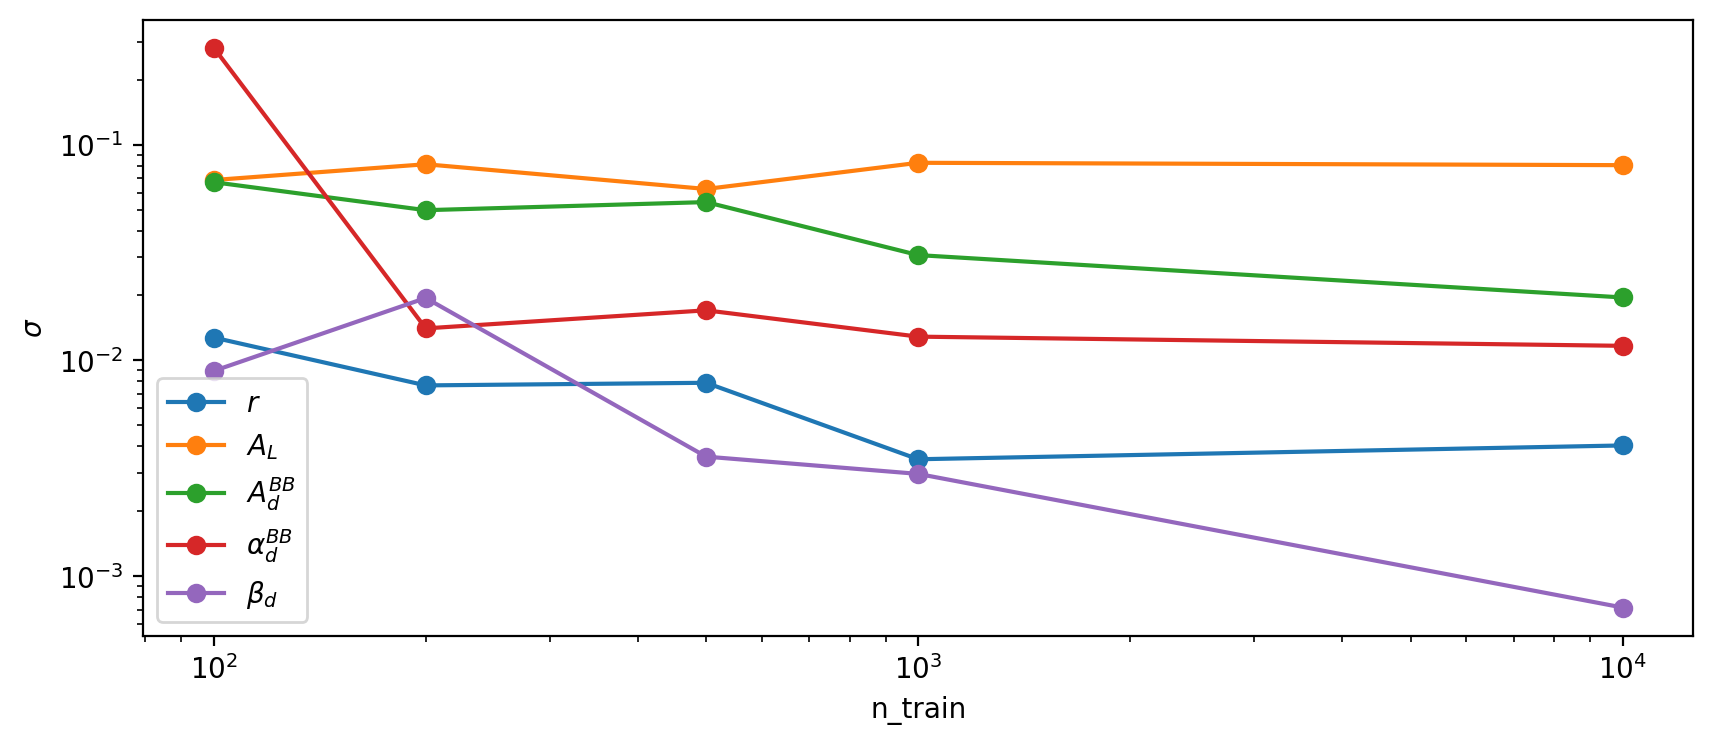

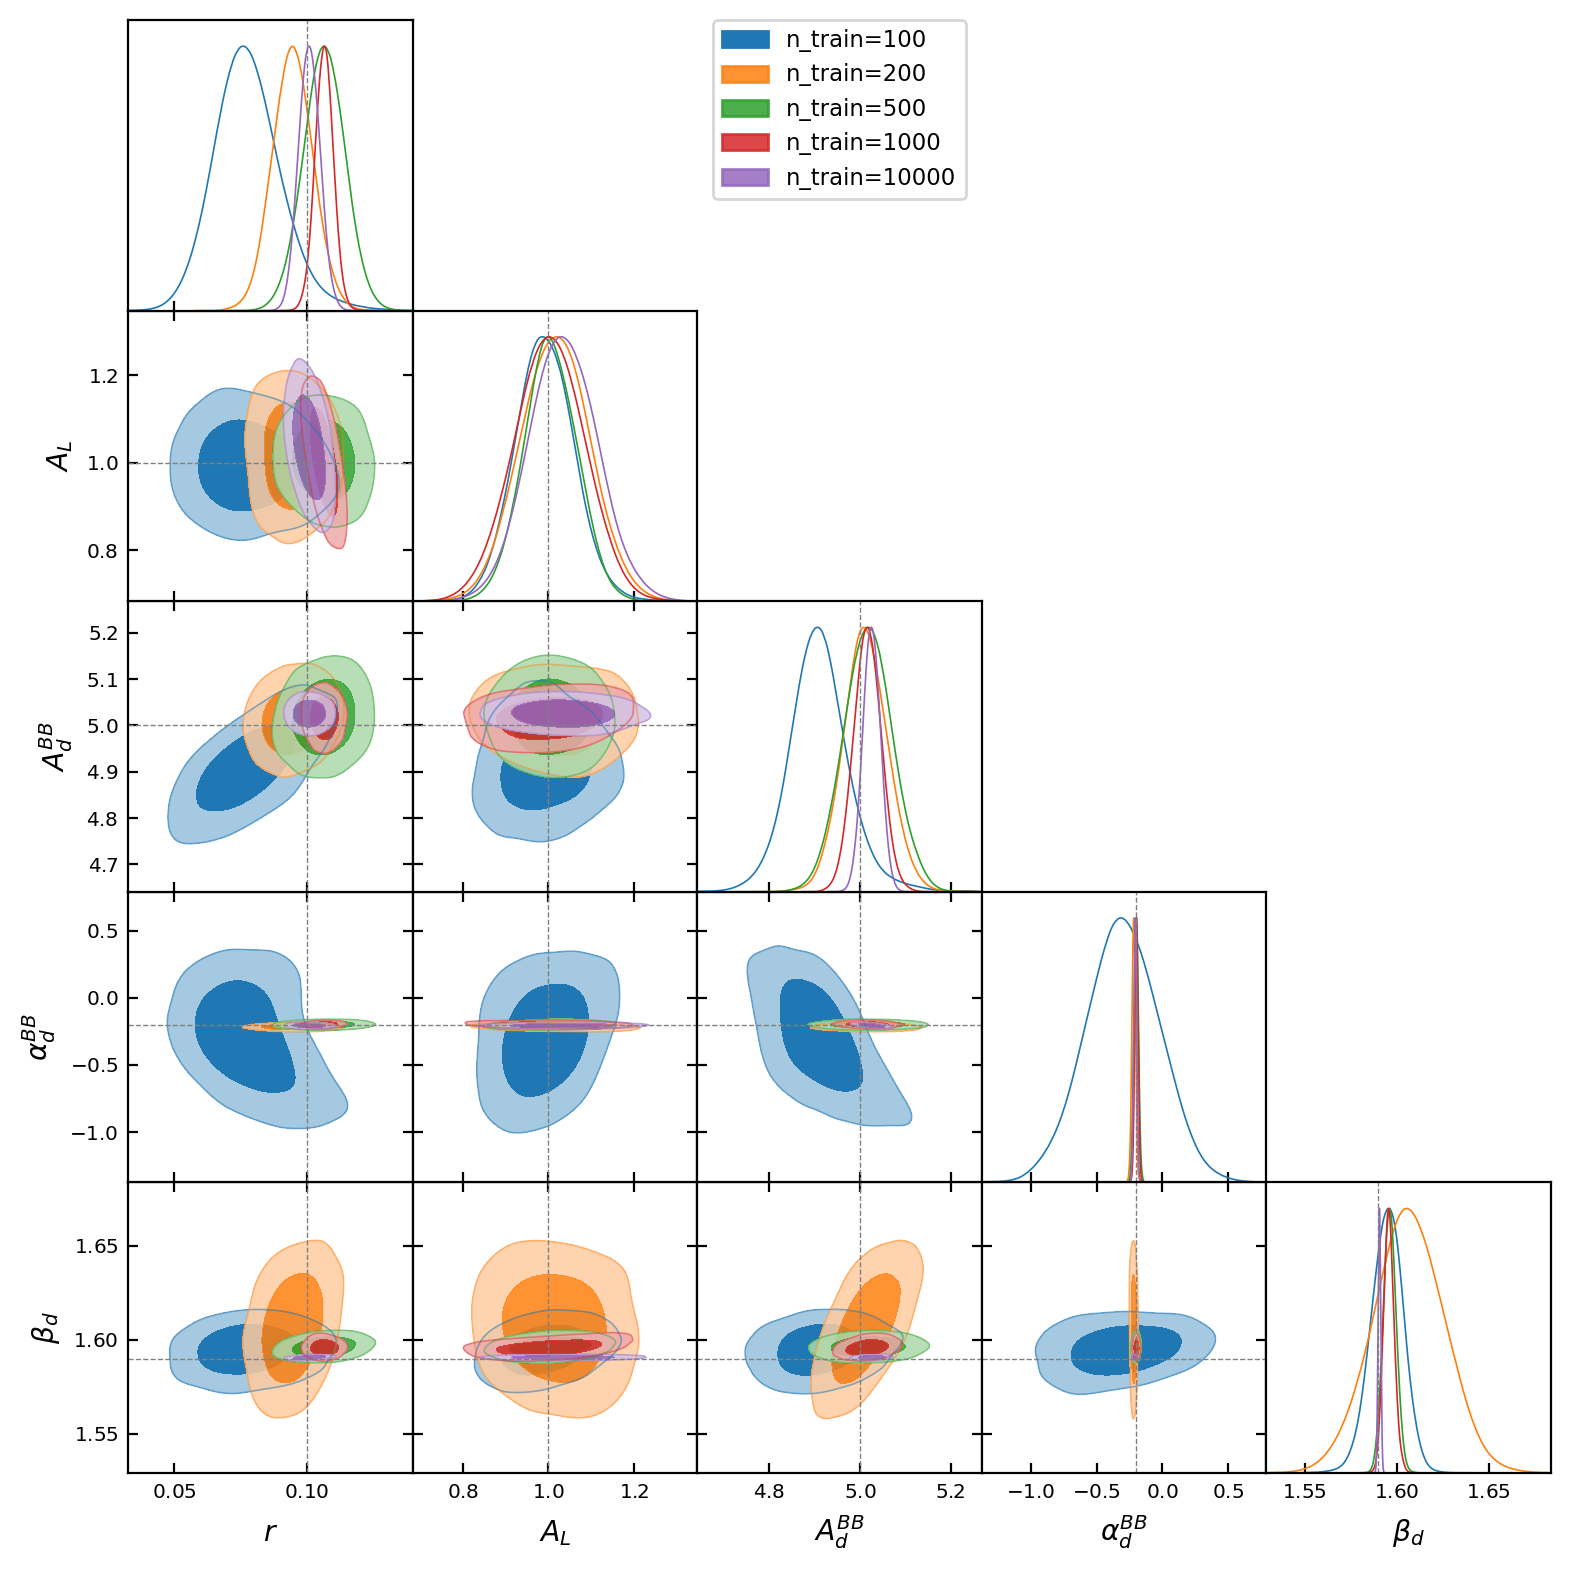

/tmp/ipykernel_151519/3448011948.py:19: FutureWarning: load_study() got {'study_name', 'storage'} as positional arguments but they were expected to be given as keyword arguments.
  study = optuna.load_study(study_name, storage)


Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in


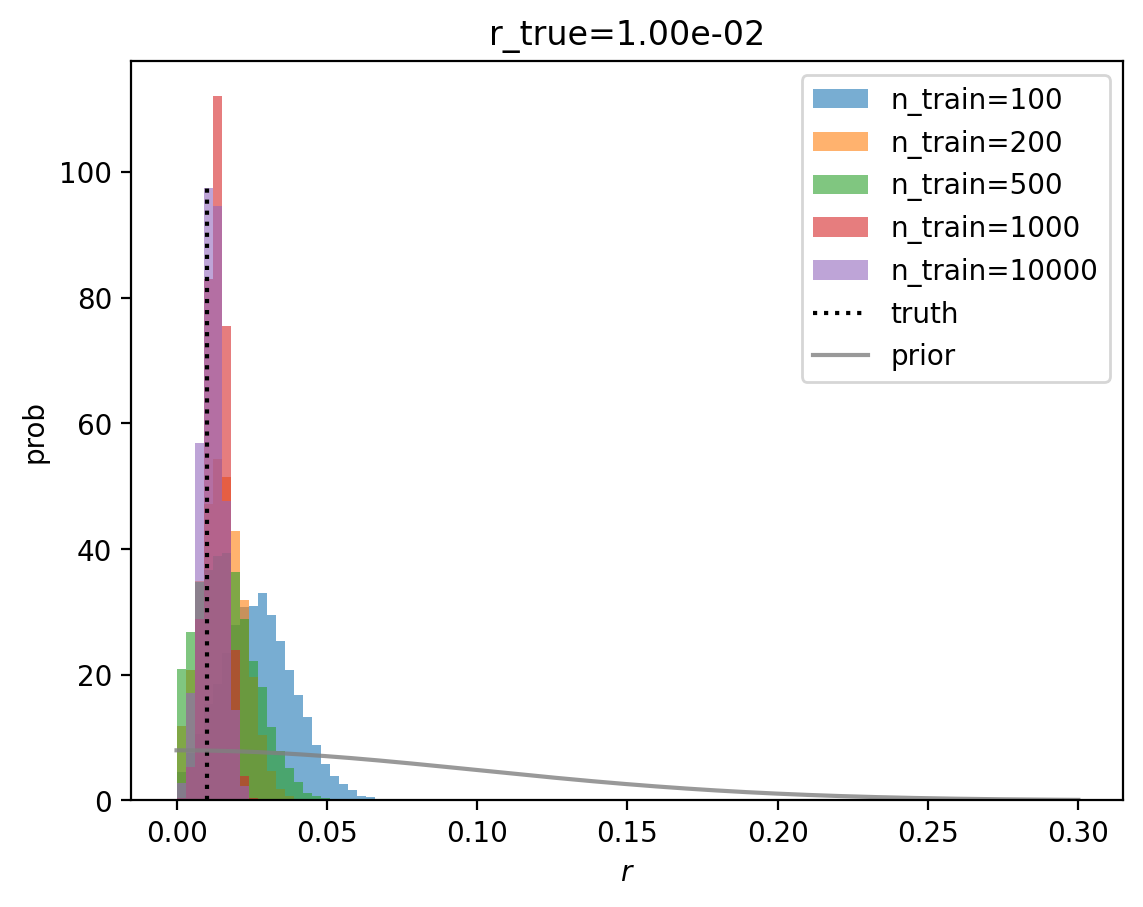

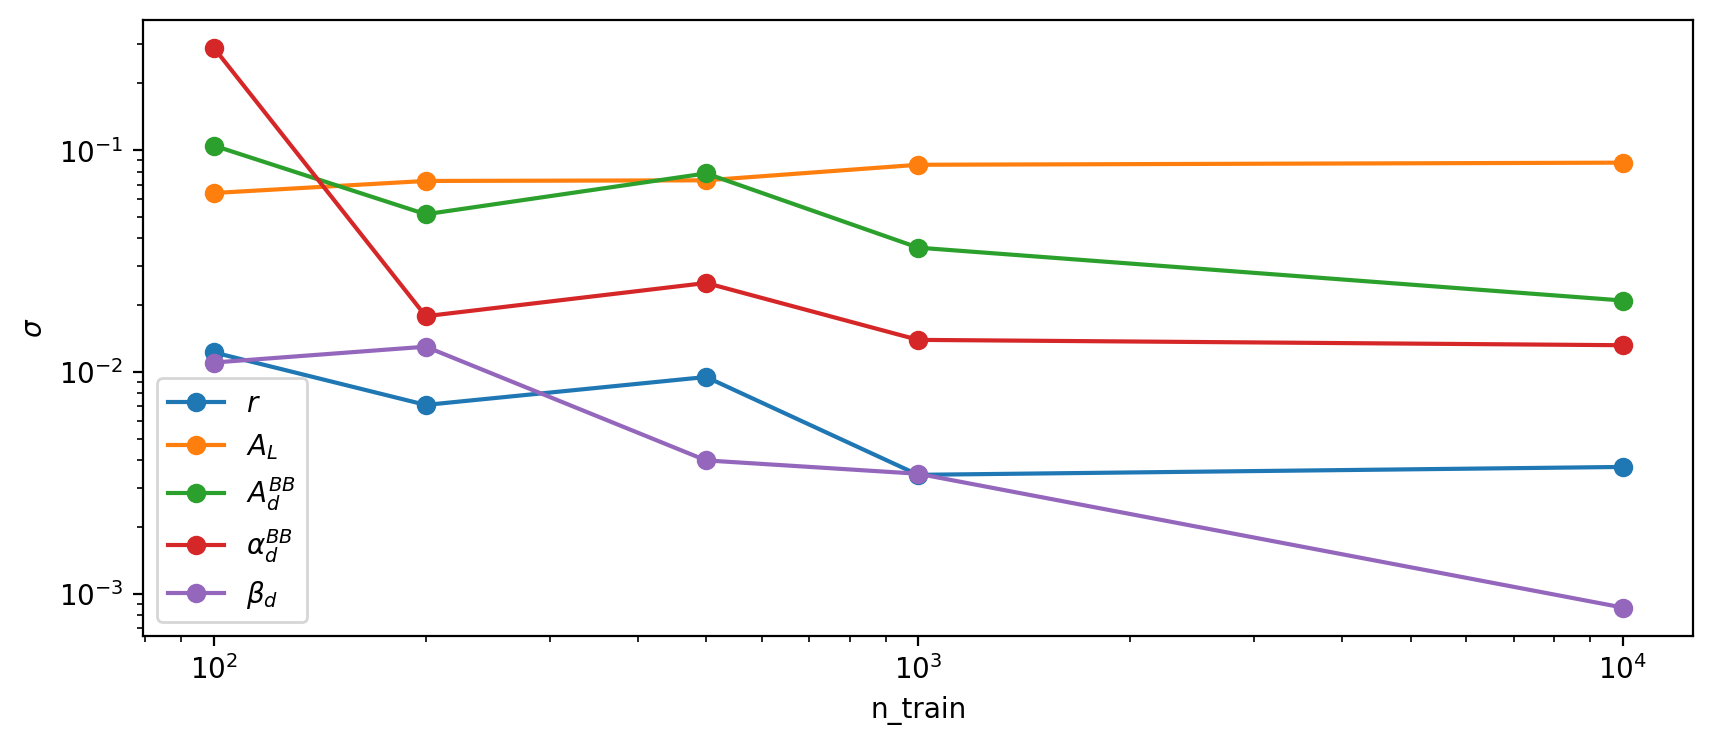

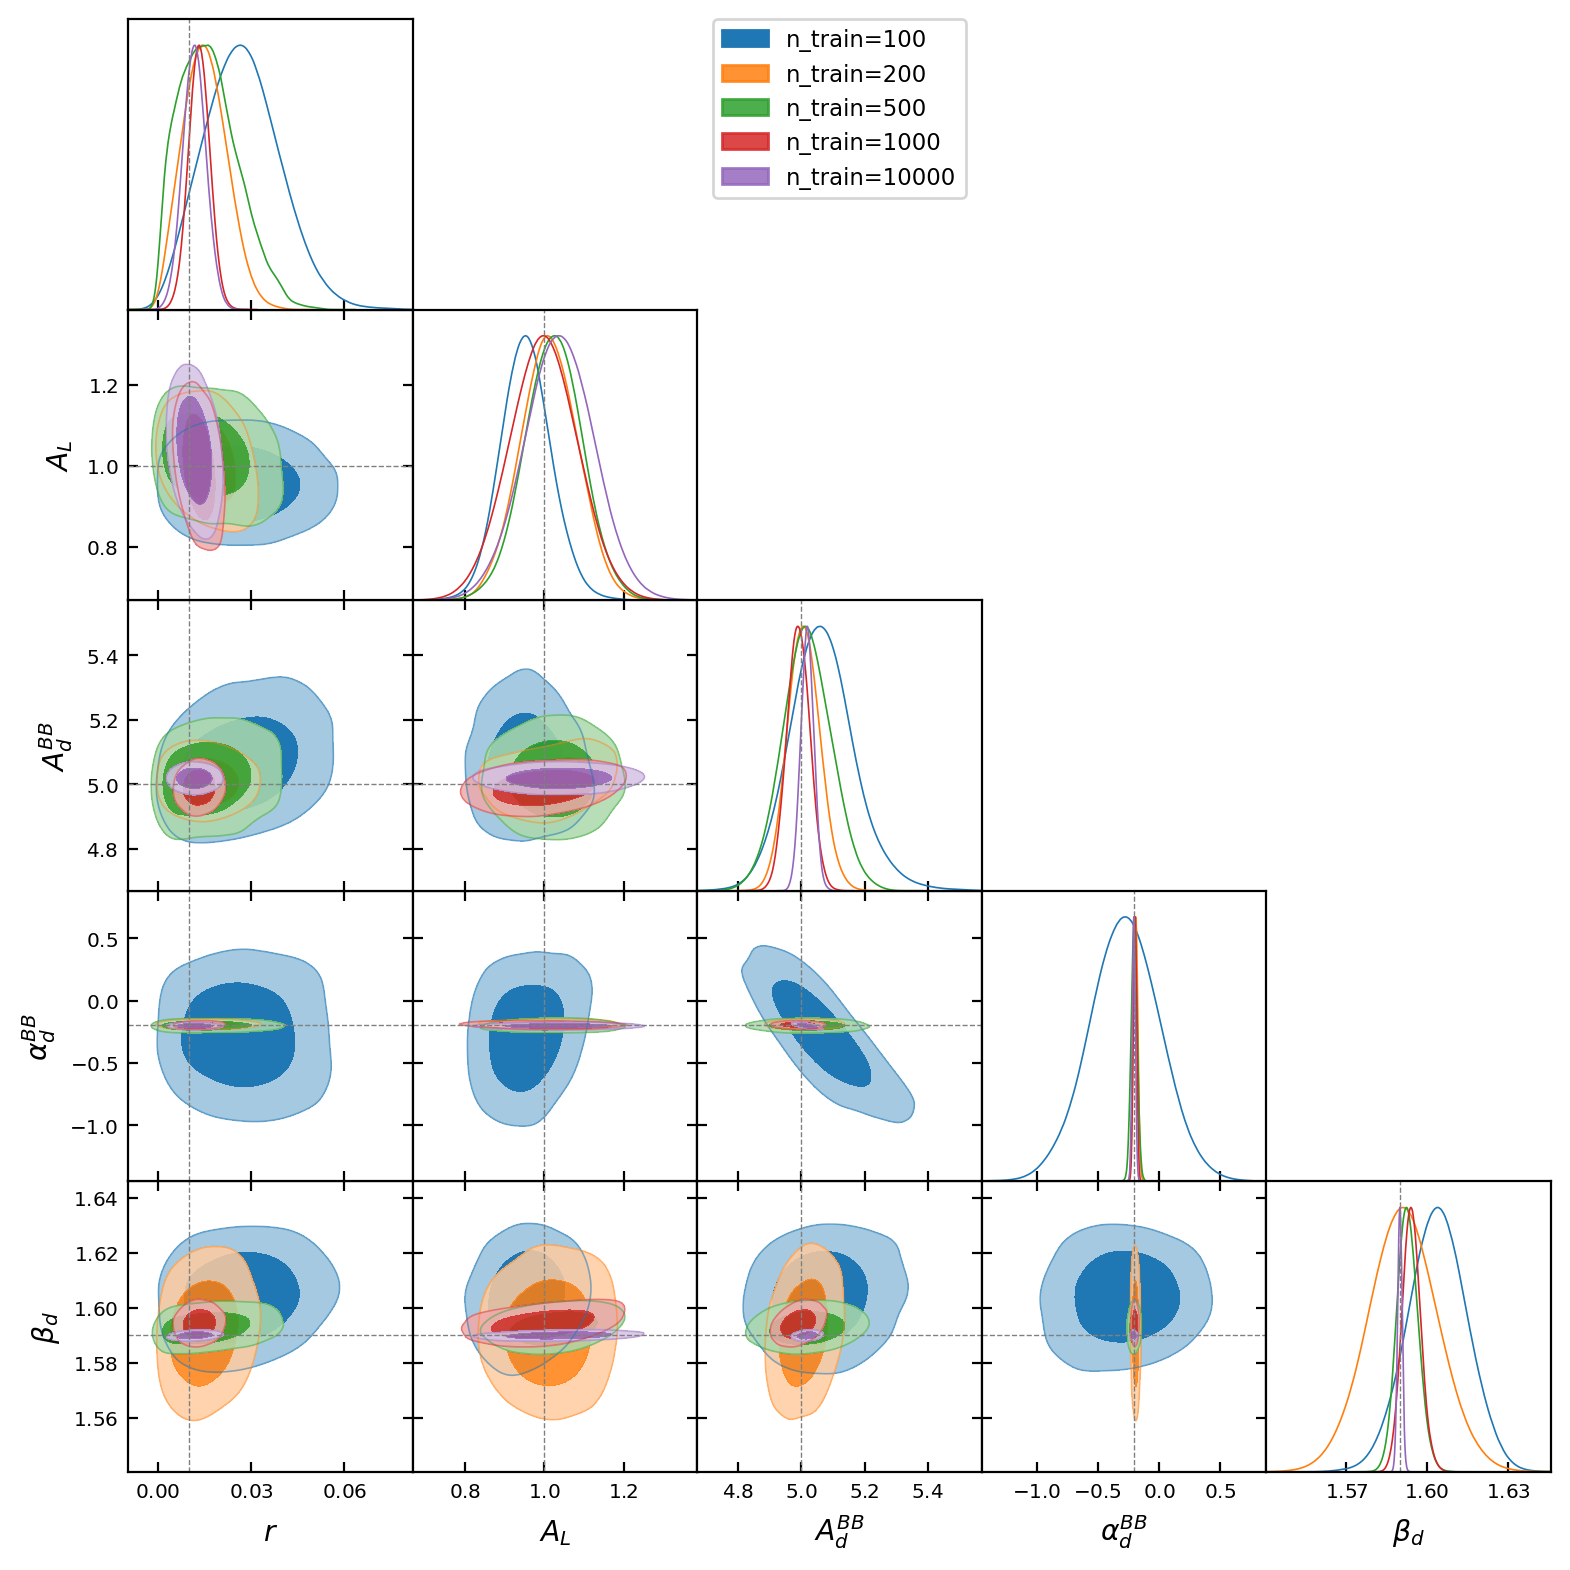

/tmp/ipykernel_151519/3448011948.py:19: FutureWarning: load_study() got {'study_name', 'storage'} as positional arguments but they were expected to be given as keyword arguments.
  study = optuna.load_study(study_name, storage)


Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in


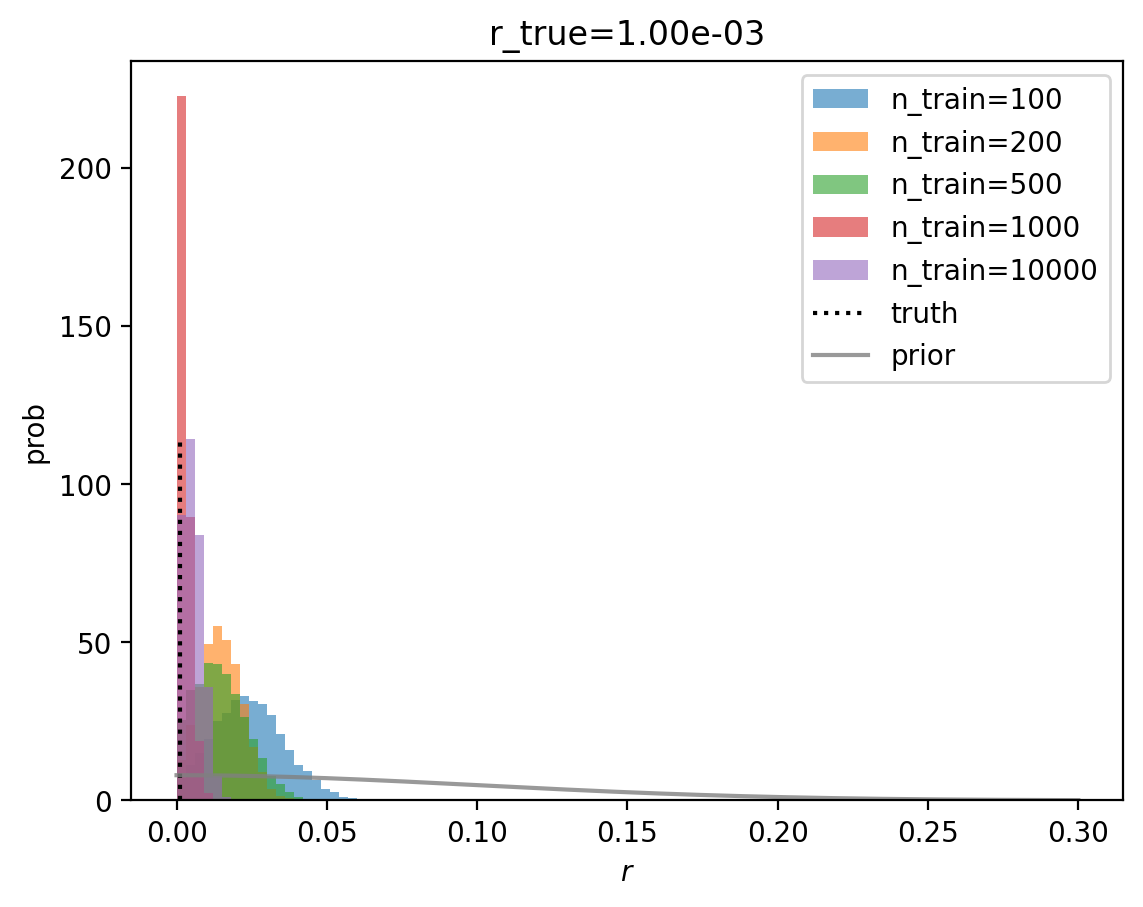

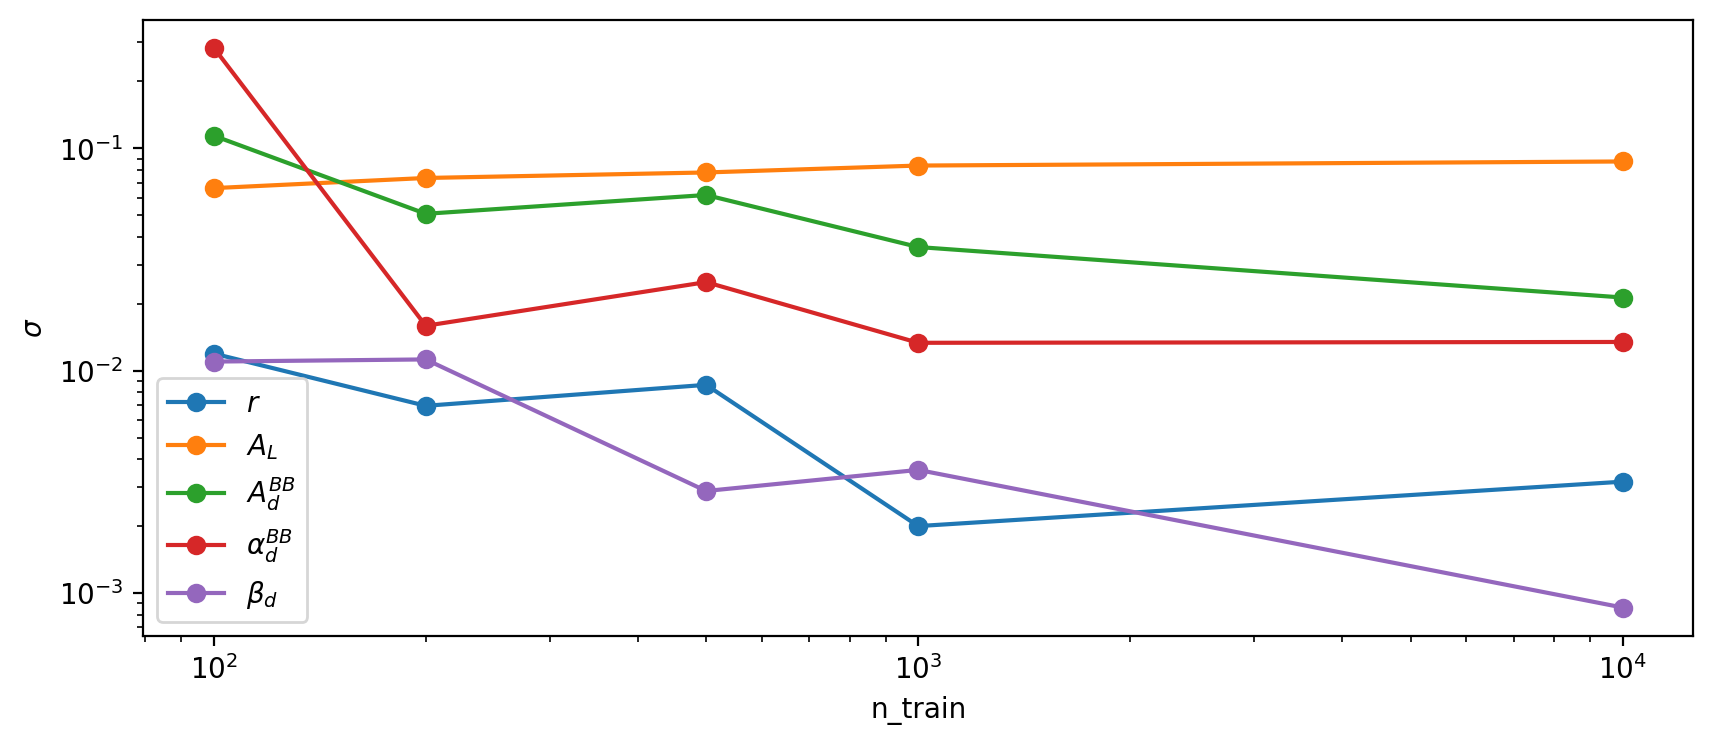

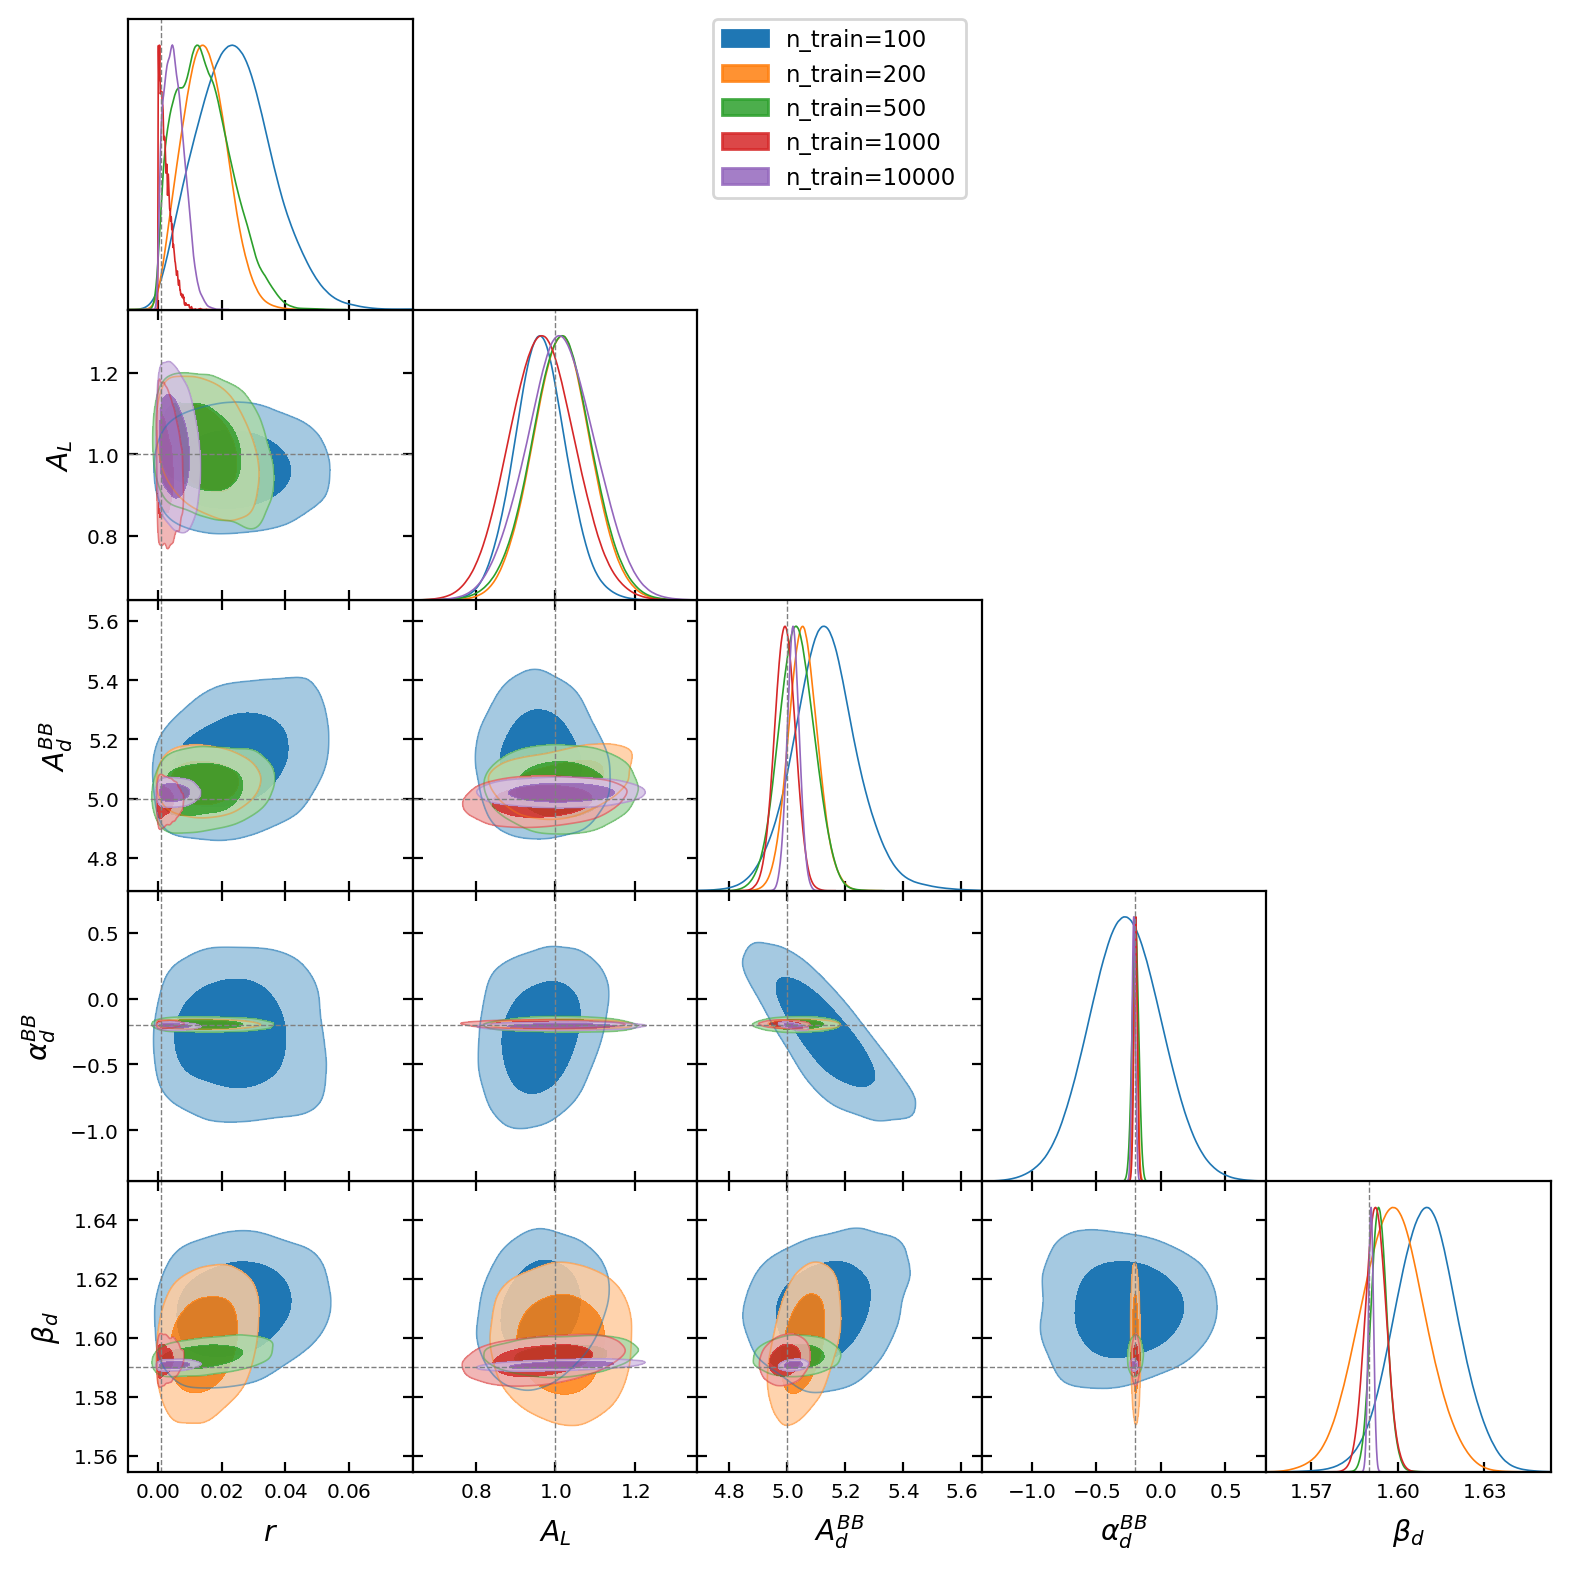

/tmp/ipykernel_151519/3448011948.py:19: FutureWarning: load_study() got {'study_name', 'storage'} as positional arguments but they were expected to be given as keyword arguments.
  study = optuna.load_study(study_name, storage)


Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in


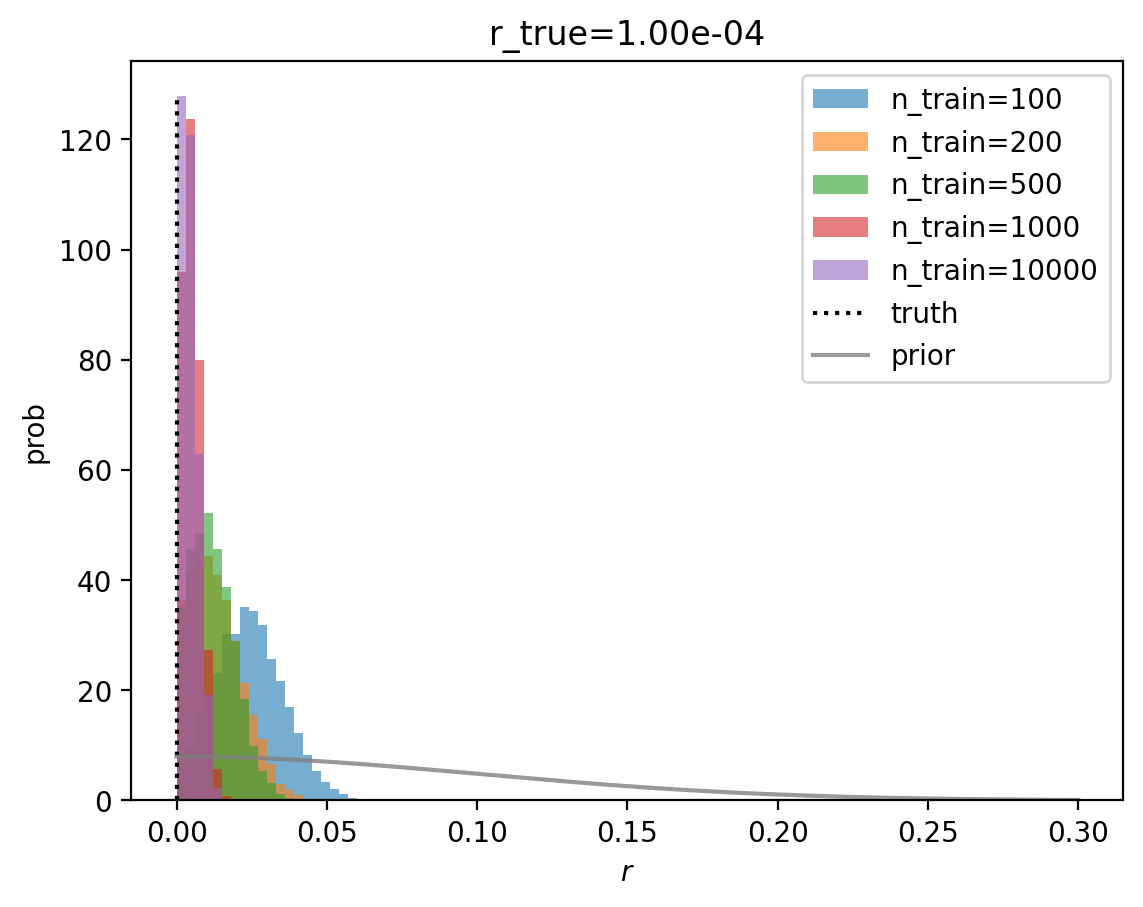

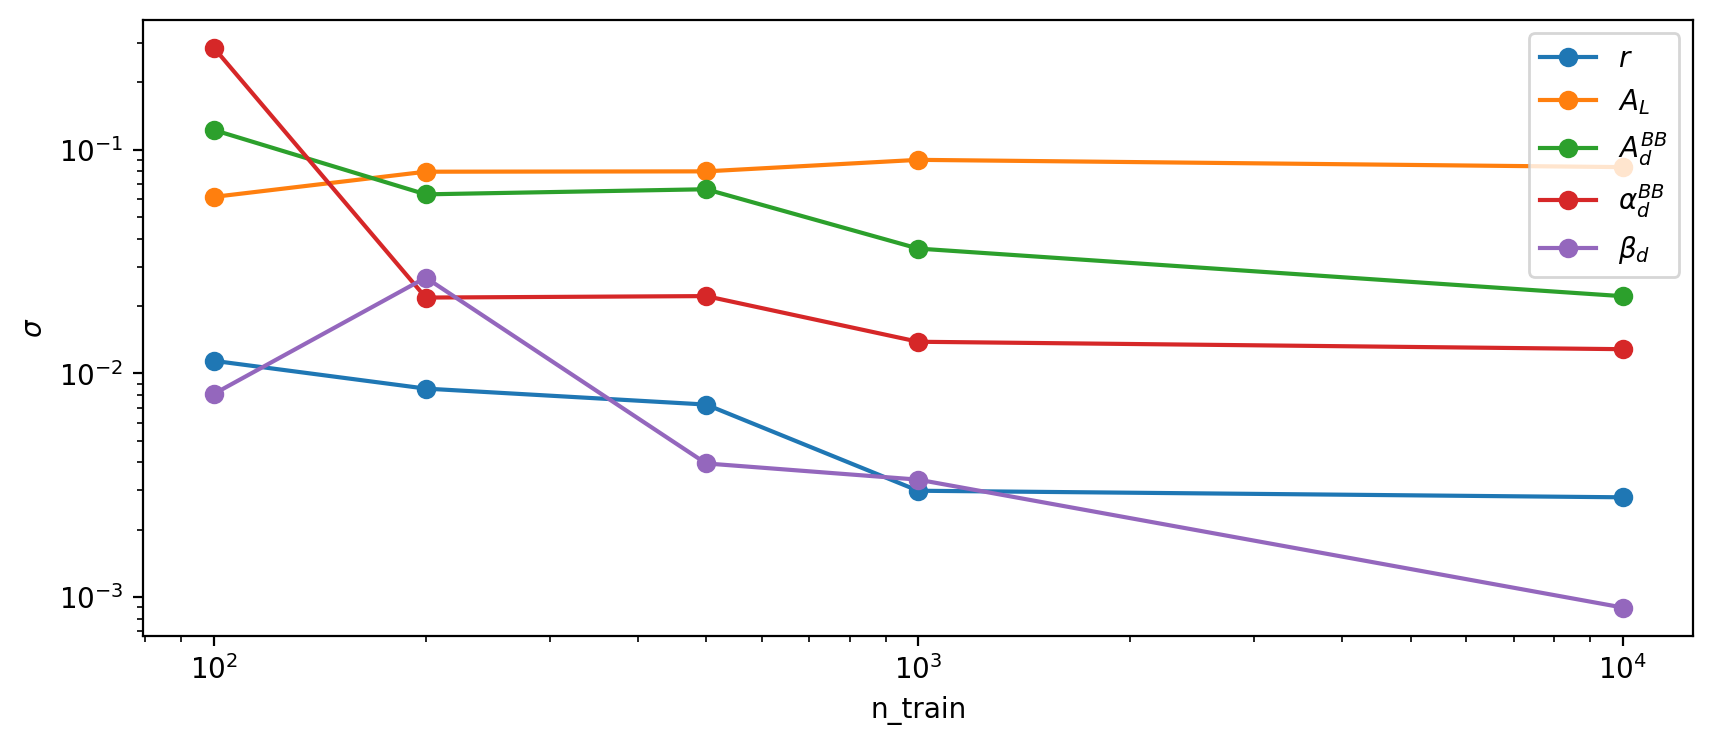

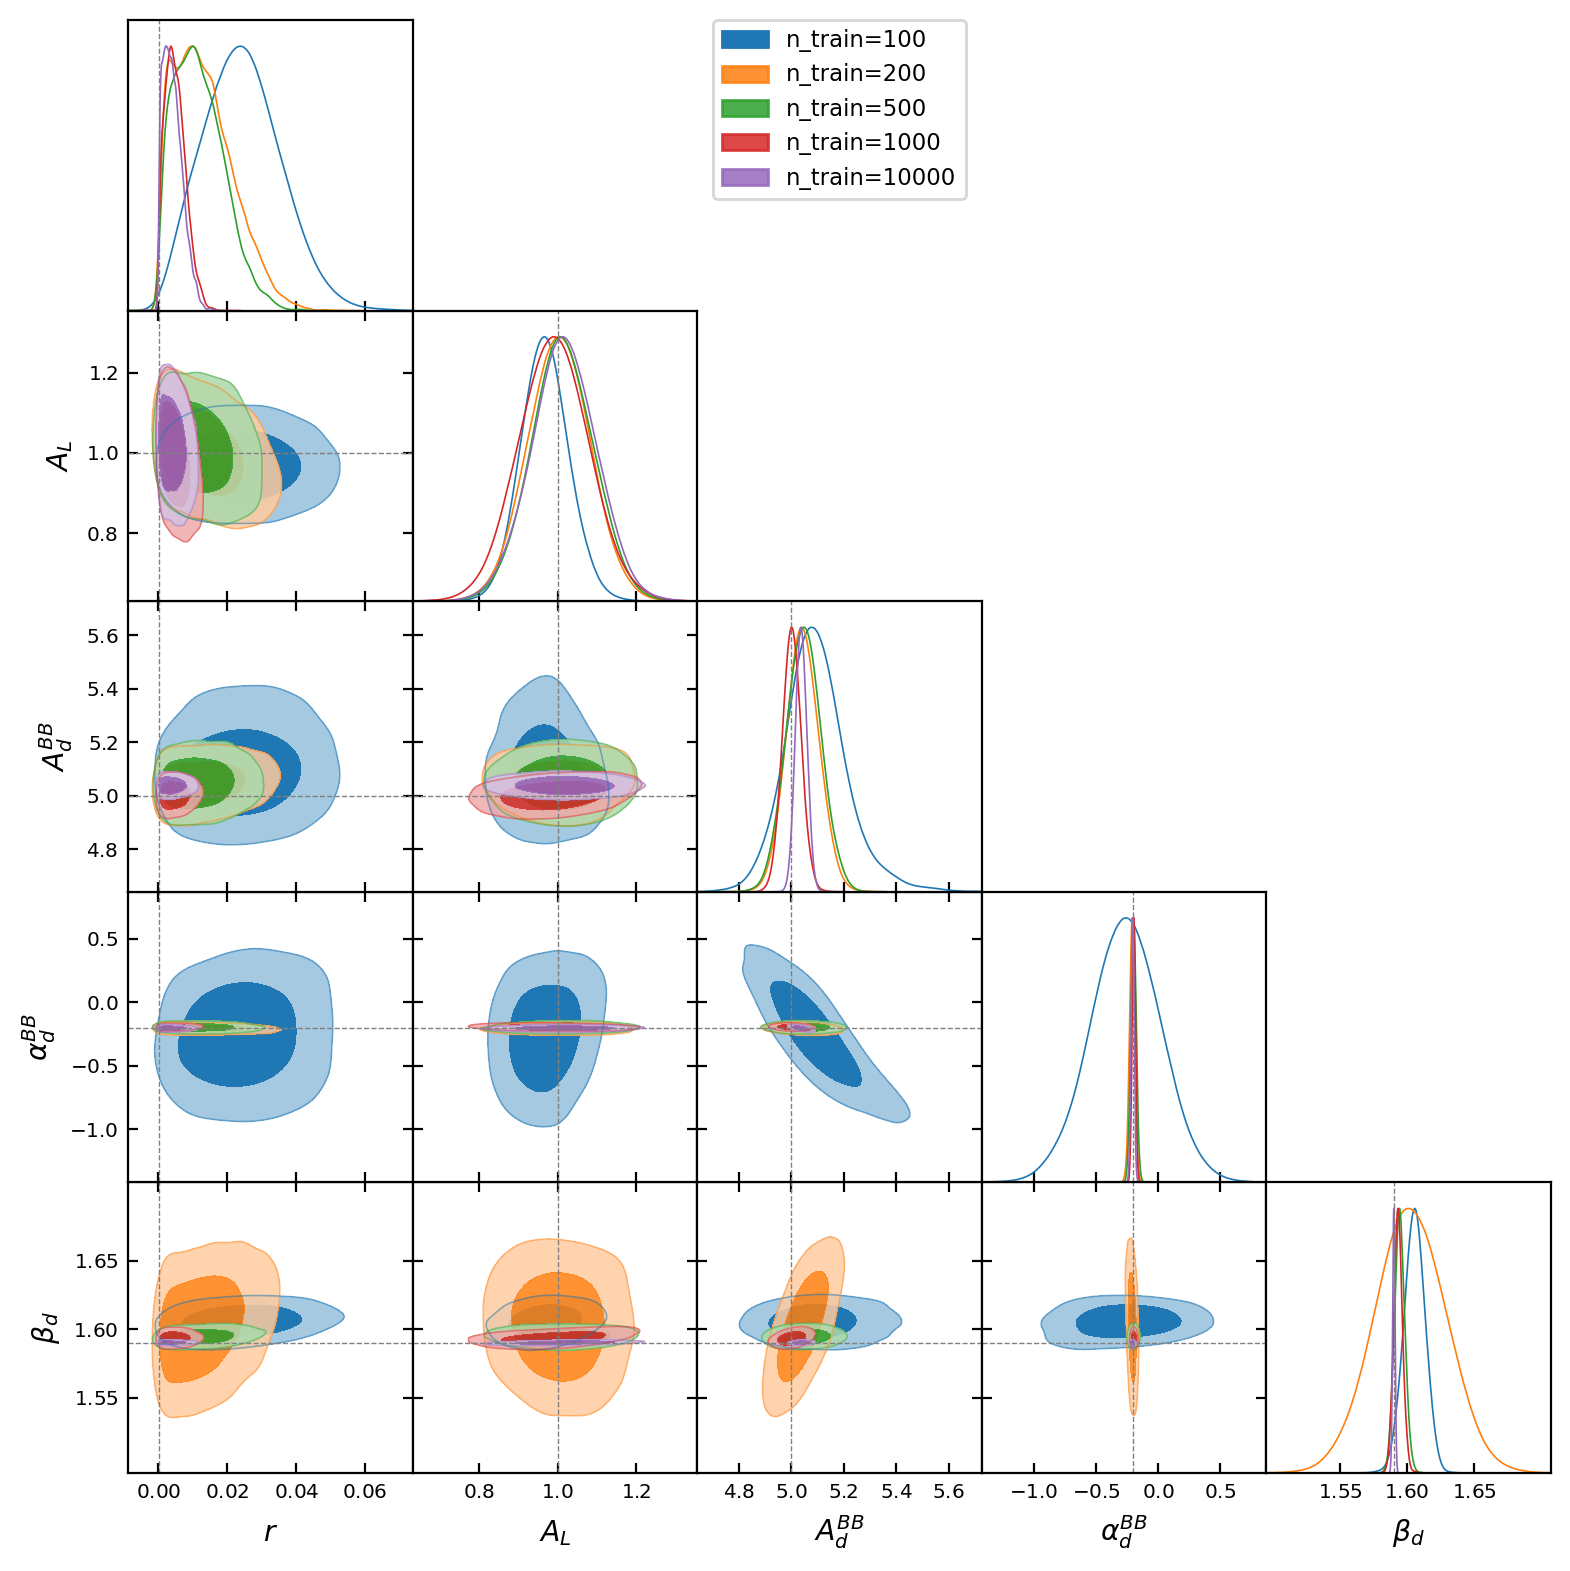

In [29]:
%matplotlib inline
%config InlineBackend.figure_format='retina'
for r_true in r_trues:
    param_truths[0] = r_true   # FIXME maybe use dict instead of indexing
    plt.figure()
    samples_g = []
    stds = np.empty((len(n_trains), n_params))
    for nti,n_train in enumerate(n_trains):
        subdirname = 'r%.2e_s%d_nt%d_ns%d_nr%d' % (r_true, seed, n_train, n_samples, n_rounds)

        # load best run from optuna:
        study_name = 'bmode_%s_na%d-%d_bs%d-%d_lr%.2e-%.2e_cm%.2e-%.2e' % \
            (subdirname,
            num_atoms0, num_atoms1, 
            training_batch_size0, training_batch_size1, 
            learning_rate0, learning_rate1, 
            clip_max_norm0, clip_max_norm1)
        storage    = 'sqlite:///bmode.db'
        study = optuna.load_study(study_name, storage)
        suffix = '_trial%d' % study.best_trial.number

        samples = np.load(opj(indir,subdirname,f'samples{suffix}.npy'))
        rsamples = samples[:,0]
        stds[nti] = np.std(samples, axis=0)

        hist=plt.hist(rsamples, bins=r_bin_edges, label='n_train=%d'%n_train, color='C%d'%nti, alpha=0.6, density=1)
        samples_g.append( getdist_MCSamples(samples=samples, names = param_labels, labels = param_labels_g, label='n_train=%d'%n_train))

    plt.vlines(r_true, 0, hist[0].max(), color='k', linestyle=':', label='truth')
    plt.plot(np.linspace(rmin,rmax,1000), np.exp(HalfNormal(0.1).log_prob(torch.linspace(rmin,rmax,1000))), color='gray', alpha=0.8, label='prior')
    plt.title('r_true=%.2e'%r_true)
    plt.xlabel(r'$r$')
    plt.ylabel('prob')
    plt.legend()
    plt.show()

    plt.figure(figsize=(10,4))
    for i in range(n_params):
        plt.plot(n_trains, stds[:,i], label=param_labels[i], marker='o')
    plt.xlabel('n_train')
    plt.ylabel(r'$\sigma$')
    plt.legend()
    plt.xscale('log')
    plt.yscale('log')
    plt.show()

    #plt.figure()
    g = getdist_plots.get_subplot_plotter(width_inch=8)
    g.triangle_plot(samples_g, filled=True,
                            markers=param_truths,
                            contour_colors=['C%d'%i for i in range(n_train)],
    )
    plt.show()